<a href="https://colab.research.google.com/github/randifajar/water-quality-classification/blob/main/predict-students-dropout-and-academic-success.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [2]:
!pip install ucimlrepo

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo
from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

## Deklarasi Fungsi

In [4]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=plt.cm.Paired
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class"]
    ax.set(
        yticks=np.arange(n_splits + 1) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 1.2, -0.2],
        xlim=[0, 6627],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

## Mengambil Dataset

In [5]:
dataset = fetch_ucirepo(id=697)

In [6]:
dataset.data.features

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0,0.000000,0,10.8,1.4,1.74
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,0,6,0,0,0.000000,0,10.8,1.4,1.74
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,0,6,8,5,12.666667,0,15.5,2.8,-4.06
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,0,6,6,2,11.000000,0,11.1,0.6,2.02
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,0,8,9,1,13.500000,0,13.9,-0.3,0.79
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,0,5,6,5,12.000000,0,9.4,-0.8,-3.12


In [7]:
dataset.data.targets

,Target
0,Dropout
1,Graduate
2,Dropout
3,Graduate
4,Graduate
...,...
4419,Graduate
4420,Dropout
4421,Dropout
4422,Graduate


In [8]:
dataset = df_gabung = pd.merge(dataset.data.features, dataset.data.targets, how='inner', left_index=True, right_index=True)
dataset

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital Status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

## Cek Missing Values

In [10]:
dataset.isna().sum().sort_values(ascending = False)

Marital Status                                    0
Age at enrollment                                 0
Curricular units 1st sem (credited)               0
Curricular units 1st sem (enrolled)               0
Curricular units 1st sem (evaluations)            0
Curricular units 1st sem (approved)               0
Curricular units 1st sem (grade)                  0
Curricular units 1st sem (without evaluations)    0
Curricular units 2nd sem (credited)               0
Curricular units 2nd sem (enrolled)               0
Curricular units 2nd sem (evaluations)            0
Curricular units 2nd sem (approved)               0
Curricular units 2nd sem (grade)                  0
Curricular units 2nd sem (without evaluations)    0
Unemployment rate                                 0
Inflation rate                                    0
GDP                                               0
International                                     0
Scholarship holder                                0
Application 

## Cek Data Target

In [11]:
dataset["Target"].unique()

array(['Dropout', 'Graduate', 'Enrolled'], dtype=object)

In [12]:
dataset['Target'] = dataset['Target'].map({'Dropout':0, 'Enrolled':1, 'Graduate':2})

In [13]:
dataset["Target"].unique()

array([0, 2, 1])

## Cek Korelasi Antar Fitur

In [14]:
dataset.corr()['Target'].sort_values(ascending = False)

Target                                            1.000000
Curricular units 2nd sem (approved)               0.624157
Curricular units 2nd sem (grade)                  0.566827
Curricular units 1st sem (approved)               0.529123
Curricular units 1st sem (grade)                  0.485207
Tuition fees up to date                           0.409827
Scholarship holder                                0.297595
Curricular units 2nd sem (enrolled)               0.175847
Curricular units 1st sem (enrolled)               0.155974
Admission grade                                   0.120889
Displaced                                         0.113986
Previous qualification (grade)                    0.103764
Curricular units 2nd sem (evaluations)            0.092721
Application order                                 0.089791
Daytime/evening attendance                        0.075107
Curricular units 2nd sem (credited)               0.054004
Curricular units 1st sem (credited)               0.0481

In [ ]:
sns.pairplot(dataset, hue='Target')

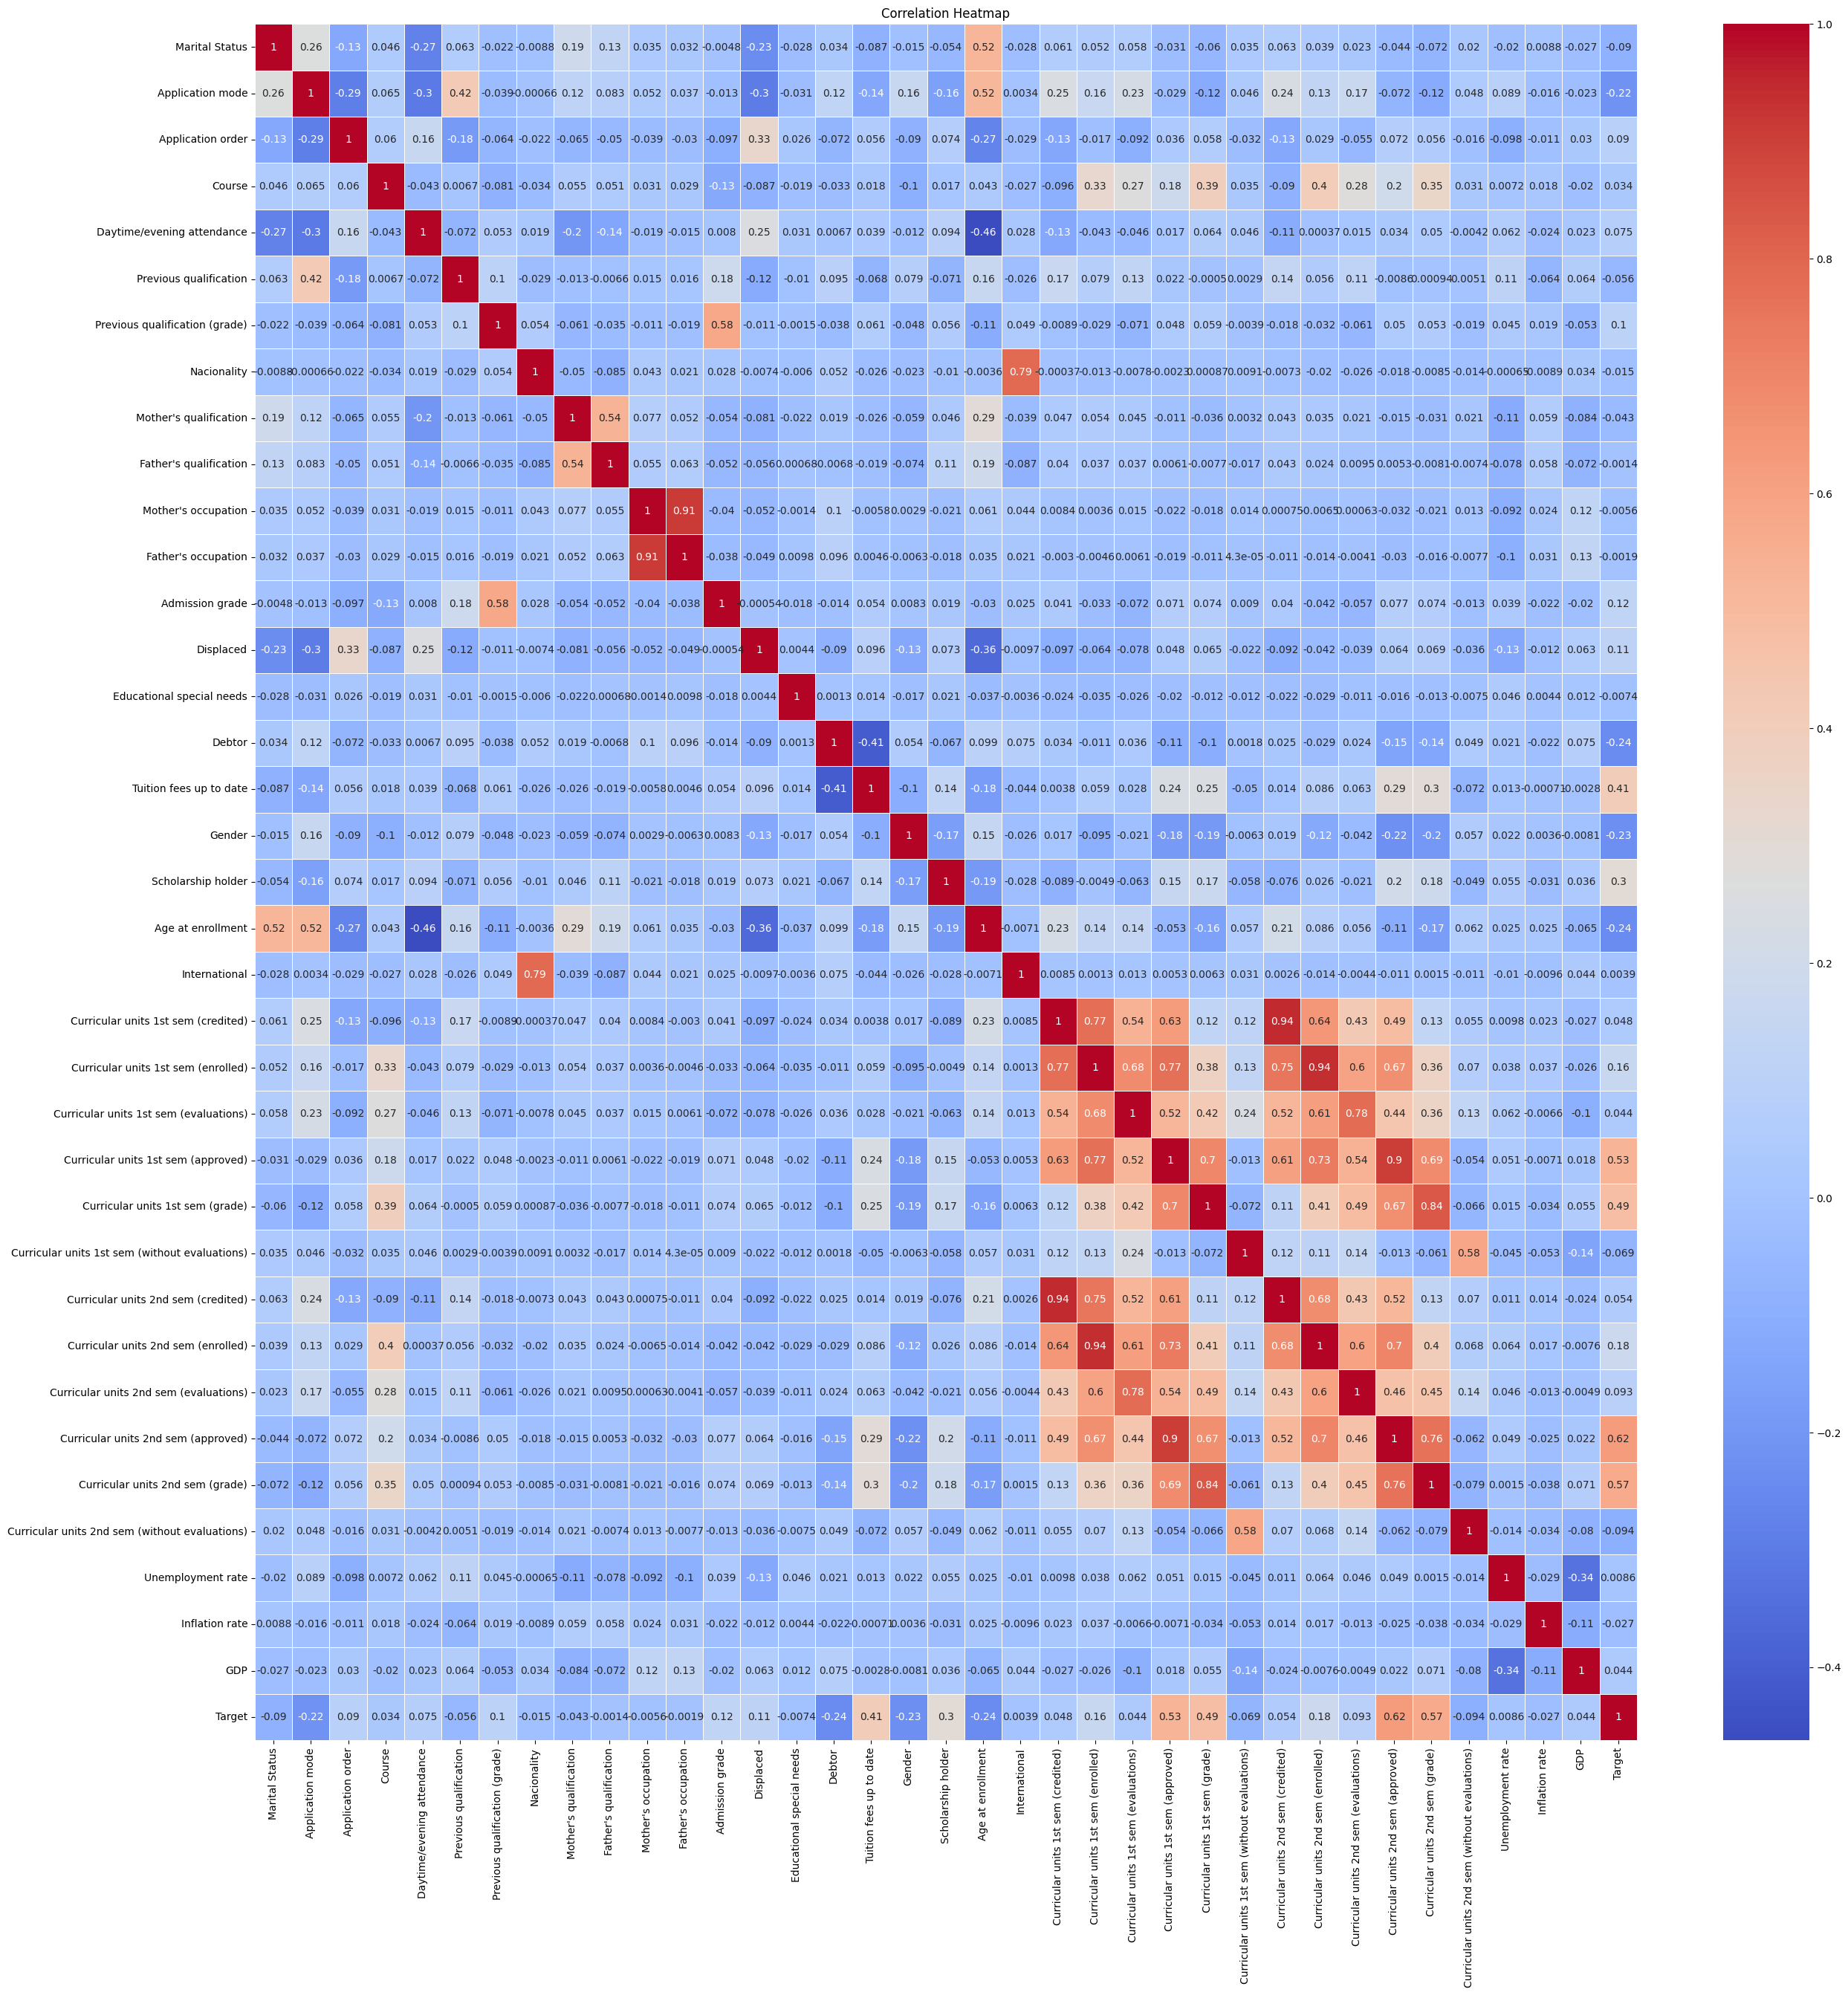

In [14]:
plt.figure(figsize=(30, 30))
sns.heatmap(dataset.corr() , annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [15]:
dataset_copy = dataset.copy()
dataset_copy = dataset_copy.drop(columns=['Unemployment rate',
                                          'International',
                                          'Father\'s qualification',
                                          'Father\'s occupation',
                                          'Mother\'s occupation',
                                          'Educational special needs',
                                          'Nacionality',
                                          'Inflation rate',
                                          'Mother\'s qualification'], axis=1)
dataset_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 28 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital Status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Admission grade                                 4424 non-null   float64
 8   Displaced                                       4424 non-null   int64  
 9   Debtor                                   

## Cek Imbalanced Data

In [42]:
X = dataset_copy.drop('Target', axis=1)
y = pd. DataFrame(dataset_copy['Target'])

In [43]:
print("Total Data: " + str(len(y)))
print(y.value_counts())

Total Data: 4424
Target
2         2209
0         1421
1          794
dtype: int64


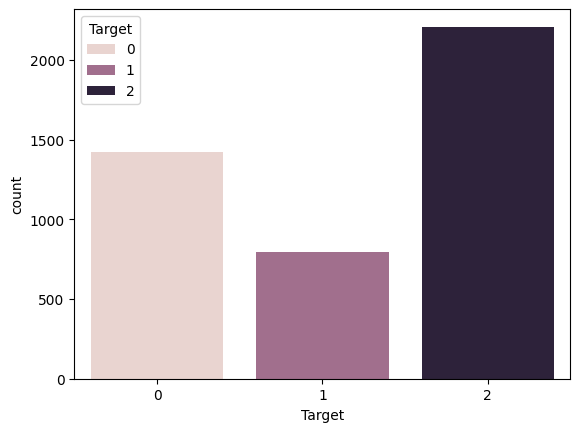

In [44]:
sns.countplot(data = y, x = 'Target', hue="Target")
plt.show()

In [45]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [46]:
print("Total Data: " + str(len(y_res)))
print(y_res.value_counts())

Total Data: 6627
Target
0         2209
1         2209
2         2209
dtype: int64


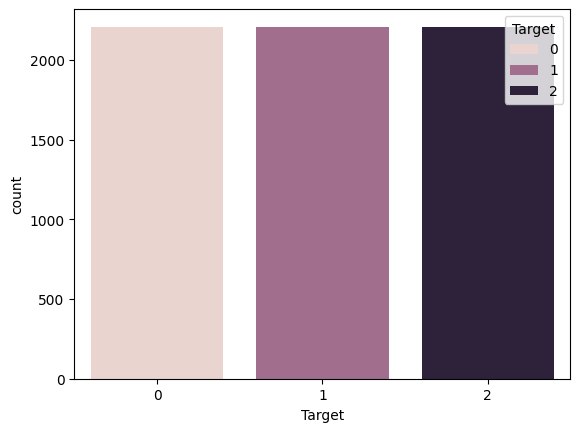

In [47]:
sns.countplot(data = y_res, x = 'Target', hue="Target")
plt.show()

## Deklarasi Algoritma Scaler dan Algoritma Classification

In [48]:
scaler = StandardScaler()
knn = KNeighborsClassifier(weights='distance', n_neighbors=11)
svc = SVC(random_state=42)
dtc = DecisionTreeClassifier(max_depth=11, random_state=42)
rfc = RandomForestClassifier(max_depth=25, max_features=4, random_state=42)

## Implementasi Algoritma Classification dengan Stratified K-Fold

In [50]:
X_res = X_res.to_numpy()
y_res = y_res.to_numpy()

In [51]:
n_splits = 5

In [52]:
SkFold = StratifiedKFold(n_splits)

<Axes: title={'center': 'StratifiedKFold'}, xlabel='Sample index', ylabel='CV iteration'>

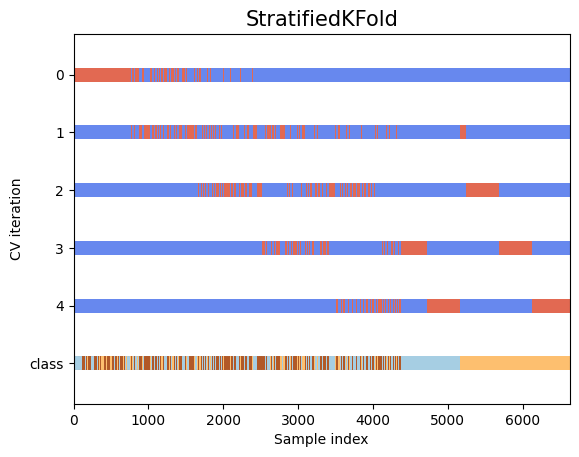

In [53]:
fig, ax = plt.subplots()
plot_cv_indices(SkFold, X_res, y_res, ax, n_splits)

In [55]:
knn_scores = []
svc_scores = []
dtc_scores = []
rfc_scores = []

for i, (train_index, test_index) in enumerate(SkFold.split(X_res, y_res)):
  X_train, X_test, y_train, y_test = X_res[train_index], X_res[test_index], y_res[train_index], y_res[test_index]

  unique, counts = np.unique(y_test, return_counts=True)

  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  knn.fit(X_train, y_train)
  svc.fit(X_train, y_train)
  dtc.fit(X_train, y_train)
  rfc.fit(X_train, y_train)

  knn_pred = knn.predict(X_test)
  svc_pred = svc.predict(X_test)
  dtc_pred = dtc.predict(X_test)
  rfc_pred = rfc.predict(X_test)

  knn_accuracy = accuracy_score(y_test, knn_pred)
  svc_accuracy = accuracy_score(y_test, svc_pred)
  dtc_accuracy = accuracy_score(y_test, dtc_pred)
  rfc_accuracy = accuracy_score(y_test, rfc_pred)

  knn_scores.append(knn_accuracy)
  svc_scores.append(svc_accuracy)
  dtc_scores.append(dtc_accuracy)
  rfc_scores.append(rfc_accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-55-7ba7de8e8a08>:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(

In [64]:
print("KNN Scores")
for i in range(n_splits):
  print("Split-" + str(i+1) + " : " + str(knn_scores[i]))

print("\nSVC Scores")
for i in range(n_splits):
  print("Split-" + str(i+1) + " : " + str(svc_scores[i]))

print("\nDTC Scores")
for i in range(n_splits):
  print("Split-" + str(i+1) + " : " + str(dtc_scores[i]))

print("\nRFC Scores")
for i in range(n_splits):
  print("Split-" + str(i+1) + " : " + str(rfc_scores[i]))

KNN Scores
Split-1 : 0.6862745098039216
Split-2 : 0.7111613876319759
Split-3 : 0.7675471698113208
Split-4 : 0.7932075471698113
Split-5 : 0.8067924528301886

SVC Scores
Split-1 : 0.7141779788838613
Split-2 : 0.7405731523378583
Split-3 : 0.7773584905660378
Split-4 : 0.8188679245283019
Split-5 : 0.8143396226415094

DTC Scores
Split-1 : 0.6990950226244343
Split-2 : 0.7171945701357466
Split-3 : 0.7637735849056604
Split-4 : 0.780377358490566
Split-5 : 0.7879245283018868

RFC Scores
Split-1 : 0.770739064856712
Split-2 : 0.77526395173454
Split-3 : 0.8256603773584905
Split-4 : 0.870188679245283
Split-5 : 0.8762264150943396


In [93]:
abc = AdaBoostClassifier(estimator=rfc, random_state=0)

In [149]:
abc_scores = []
abc_reports = []
abc_conf = []
abc_y_tests = []
abc_y_preds = []

for i, (train_index, test_index) in enumerate(SkFold.split(X_res, y_res)):
  X_train, X_test, y_train, y_test = X_res[train_index], X_res[test_index], y_res[train_index], y_res[test_index]

  unique, counts = np.unique(y_test, return_counts=True)

  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  abc.fit(X_train, y_train)
  y_pred = abc.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred)

  abc_scores.append(accuracy)
  abc_reports.append(report)
  abc_conf.append(cm)
  abc_y_tests.append(y_test.reshape(-1))
  abc_y_preds.append(y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [134]:
print("ABC Scores")
for i in range(n_splits):
  print("Split-" + str(i+1) + " : " + str(abc_scores[i]))

ABC Scores
Split-1 : 0.7722473604826546
Split-2 : 0.7737556561085973
Split-3 : 0.8309433962264151
Split-4 : 0.8671698113207548
Split-5 : 0.8807547169811321


In [135]:
print("ABC Report")
for i in range(n_splits):
  print("----------------------------------------------------------------\n")
  print("Split-" + str(i+1) + " : " + str(abc_reports[i]))

ABC Report
----------------------------------------------------------------

Split-1 :               precision    recall  f1-score   support

           0       0.87      0.78      0.82       442
           1       0.76      0.66      0.70       442
           2       0.71      0.88      0.79       442

    accuracy                           0.77      1326
   macro avg       0.78      0.77      0.77      1326
weighted avg       0.78      0.77      0.77      1326

----------------------------------------------------------------

Split-2 :               precision    recall  f1-score   support

           0       0.84      0.77      0.80       442
           1       0.76      0.68      0.72       442
           2       0.74      0.88      0.80       442

    accuracy                           0.77      1326
   macro avg       0.78      0.77      0.77      1326
weighted avg       0.78      0.77      0.77      1326

----------------------------------------------------------------

Split-3 :

ABC Confusion Matrix
Split-1 : 


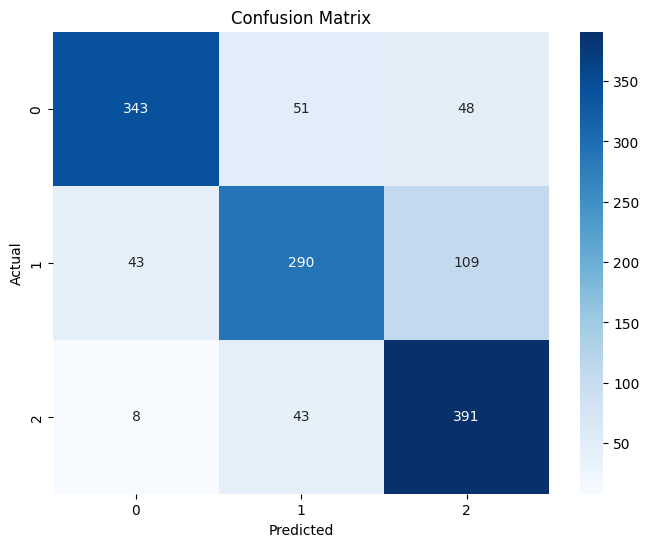

Split-2 : 


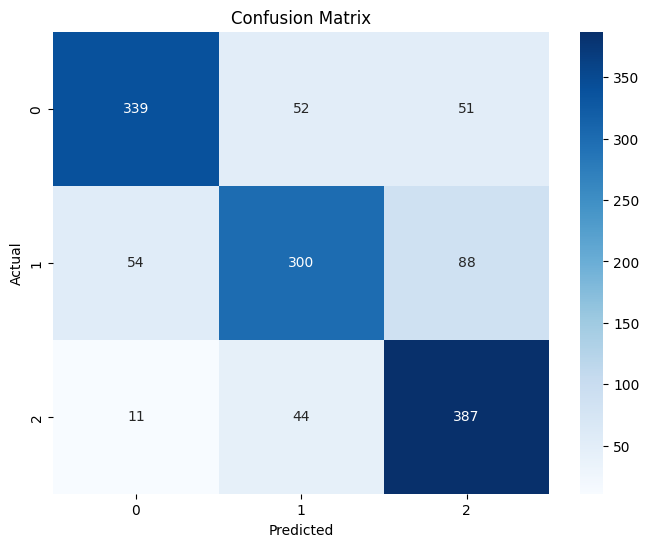

Split-3 : 


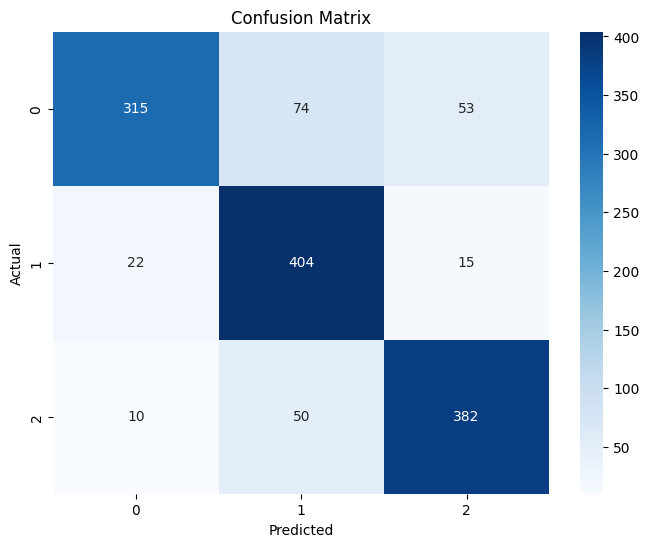

Split-4 : 


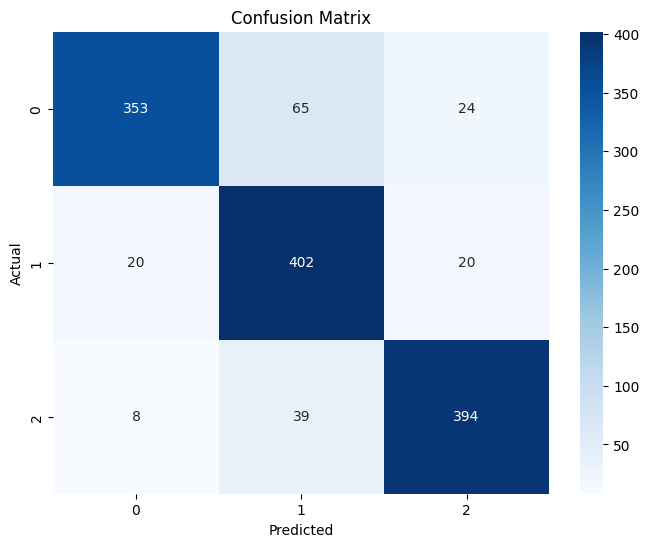

Split-5 : 


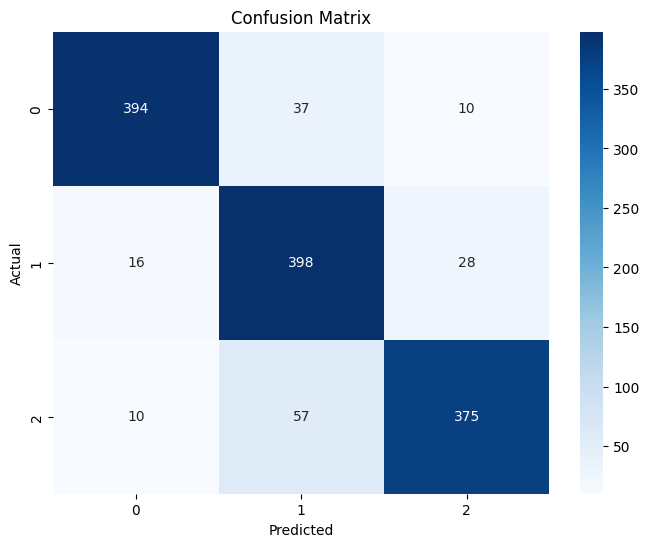

In [152]:
print("ABC Confusion Matrix")
for i in range(n_splits):
  print("Split-" + str(i+1) + " : ")
  cm = abc_conf[i]
  class_labels = np.unique(np.concatenate((abc_y_tests[i], abc_y_preds[i])))
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()